In [1]:
import os
import umap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

import warnings
warnings.filterwarnings('ignore')

/home/cshdtian/anaconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-05 14:23:31.911425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-05 14:23:32.027486: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-05 14:23:32.053531: E tensorflow/stream_executor/cuda/cuda_blas.cc:

In [2]:
y_locator_scale = {
    'ilsvrc_2012': 0.2,
    'omniglot': 0.2,
    'aircraft': 0.2,
    'cu_birds': 0.2,
    'dtd': 0.2,
    'quickdraw': 0.2,
    'fungi': 0.2,
    'vgg_flower': 0.2
}

In [3]:
def read_data(data_path:str):
    return np.load(data_path, allow_pickle=True).item()

def svd(X, n_components=2):
    U, S, Vt = np.linalg.svd(X)
    return U[:, :n_components] * S[:n_components]

In [4]:
def draw_gap_map(dataset_name:str, type:str='orig'):
    data_path = os.path.join('./', dataset_name, f'val_modality_gap.npy')
    data_dict = read_data(data_path=data_path)
    if type == 'img':
        context_data, prototypes = data_dict['origin_img'], data_dict['origin_protos']
    if type == 'orig':
        context_data, prototypes = data_dict['images'], data_dict['prototypes']
    elif type == 'url':
        context_data, prototypes = data_dict['transformed_images'], data_dict['transformed_prototypes']
    elif type == 'copa':
        context_data, prototypes = data_dict['copa_images'], data_dict['copa_prototypes']

    context_data /= np.linalg.norm(context_data, axis=-1, keepdims=True) + 1e-12
    prototypes /= np.linalg.norm(prototypes, axis=-1, keepdims=True) + 1e-12
    
    feature_2d = svd(np.concatenate([context_data, prototypes], 0))

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    ax.patch.set_facecolor('#D3D3D3')
    ax.scatter(feature_2d[:len(context_data), 0], feature_2d[:len(context_data), 1], s=300, c='#2A9D8F', label='images')
    ax.scatter(feature_2d[len(context_data):, 0], feature_2d[len(context_data):, 1], s=300, c='#E76F51', label='prototypes', marker='^')

    for i in range(len(context_data)):
        ax.plot([feature_2d[i, 0], feature_2d[len(context_data)+i, 0]], 
                [feature_2d[i, 1], feature_2d[len(context_data)+i, 1]],
                c='black', alpha=0.1)
    
    delta = np.linalg.norm(np.mean(context_data, axis=0) - np.mean(prototypes, axis=0))
    print(f"The gap on {type} is: {delta}")

    y_major_locator = MultipleLocator(0.4)
    ax.yaxis.set_major_locator(y_major_locator)
    font = {'weight': 'bold', 'size': 14}
    plt.legend(prop=font, framealpha=0.5)
    #plt.text()
    plt.tick_params(labelsize=14)
    plt.grid(True)

    save_path = os.path.join('./figs', dataset_name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    if type == 'img':
        fig_name = os.path.join(save_path, dataset_name+'_modality_gap_image.pdf')
    elif type == 'orig':
        fig_name = os.path.join(save_path, dataset_name+'_modality_gap.png')
    elif type == 'url':
        fig_name = os.path.join(save_path, dataset_name+'_modality_gap_url.png')
    elif type == 'copa':
        fig_name = os.path.join(save_path, dataset_name+'_modality_gap_copa.png')
    plt.savefig(fig_name, dpi=300, bbox_inches='tight')

    plt.show()


def plot_feat_umap(dataset_name:str, type:str='orig'):
    data_path = os.path.join('./', dataset_name, f'val_modality_gap.npy')
    data_dict = read_data(data_path=data_path)
    
    if type == 'img':
        context_data = data_dict['origin_img']
    if type == 'orig':
        context_data = data_dict['images']
    elif type == 'url':
        context_data = data_dict['transformed_images']
    elif type == 'copa':
        context_data = data_dict['copa_images']
    context_data /= np.linalg.norm(context_data, axis=-1, keepdims=True) + 1e-12
    labels = data_dict['labels']

    reducer = umap.UMAP(random_state=42)
    embeddings = reducer.fit_transform(context_data)
    print(embeddings.shape, labels.shape)

    scale = np.round((np.max(embeddings[:, 1]) - np.min(embeddings[:, 1])) / 4., 0)
    
    # figure plot settings
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    ax.patch.set_facecolor('#D3D3D3')

    ax.scatter(embeddings[:, 0], embeddings[:, 1], c=list(labels), s=50)
    y_axis_locator = MultipleLocator(scale)
    ax.yaxis.set_major_locator(y_axis_locator)
    plt.tick_params(labelsize=14)
    plt.grid(True)

    save_path = os.path.join('./figs', 'umap_cluster')
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    if type == 'img':
        fig_name = os.path.join(save_path, dataset_name+'_cluster_image.pdf')
    elif type == 'orig':
        fig_name = os.path.join(save_path, dataset_name+'_cluster_embed.pdf')
    elif type == 'url':
        fig_name = os.path.join(save_path, dataset_name+'_cluster_url.pdf')
    elif type == 'copa':
        fig_name = os.path.join(save_path, dataset_name+'_cluster_copa.pdf')
    plt.savefig(fig_name, dpi=300, bbox_inches='tight')

    plt.show()


def gaps(dataset_name):
    data_path = os.path.join('./total_gap', 'total_gaps.npy')
    data = read_data(data_path)

    orig_gap = data['orig_gap']
    url_gap = data['url_gap']
    copa_gap = data['copa_gap']

    orig_mean, orig_std = np.array(orig_gap).mean(), np.array(orig_gap).std()
    url_mean, url_std = np.array(url_gap).mean(), np.array(url_gap).std()
    copa_mean, copa_std = np.array(copa_gap).mean(), np.array(copa_gap).std()

    plt.figure(figsize=(6, 4))
    sns.distplot(orig_gap, color='#C82423', norm_hist=True, label="Origin Gap ($\mu_{pos}$=%.2f, $\sigma_{pos}$=%.2f)"%(orig_mean, orig_std))
    sns.distplot(url_gap, color='#2878B5', norm_hist=True, label="URL Gap ($\mu_{neg}$=%.2f, $\sigma_{neg}$=%.2f)"%(url_mean, url_std))
    sns.distplot(copa_gap, color='#8ECFC9', norm_hist=True, label="CoPA Gap ($\mu_{neg}$=%.2f, $\sigma_{neg}$=%.2f)"%(copa_mean, copa_std))

    plt.grid(True)
    plt.tick_params(axis='both', labelsize=16)
    plt.xlabel("Similarity", fontsize=16, weight='bold')
    plt.ylabel("Density", fontsize=16, weight='bold')
    font = {'weight': 'bold', 'size': 12}
    plt.legend(loc='best', prop=font, framealpha=0.5)

    save_path = os.path.join('./figs/total_gaps', dataset_name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    plt.savefig(os.path.join(save_path, dataset_name+'_avg_prototype.pdf'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


ilsvrc_2012
(237, 2) (237,)


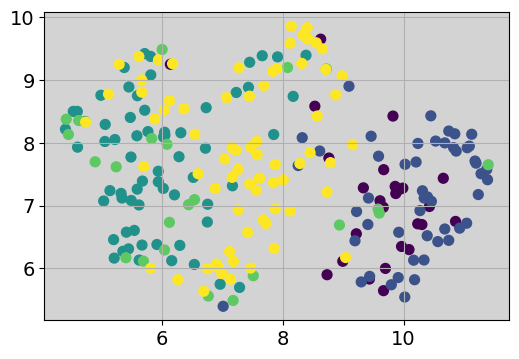

(237, 2) (237,)


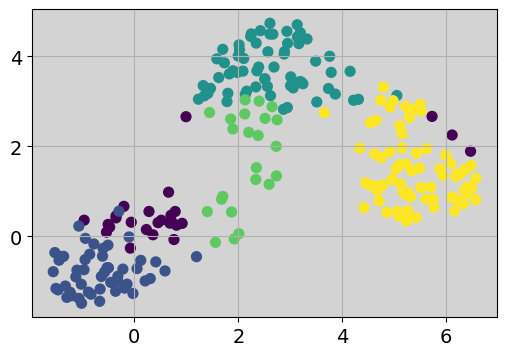

(237, 2) (237,)


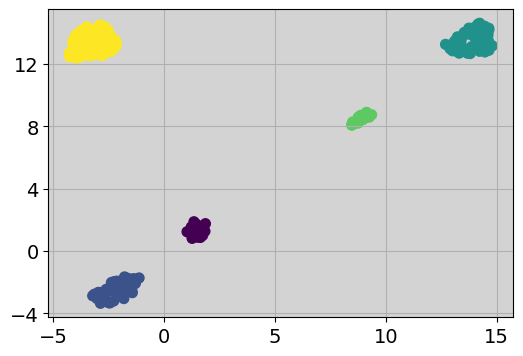

omniglot
(61, 2) (61,)


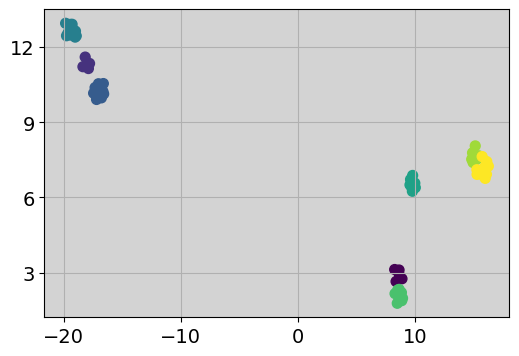

(61, 2) (61,)


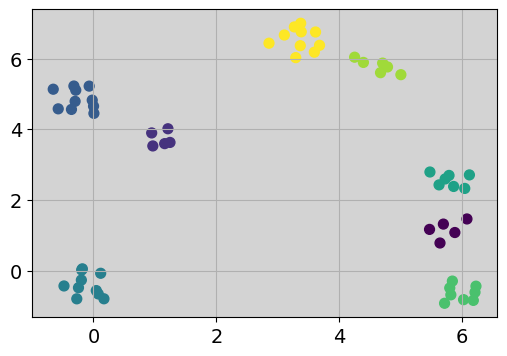

(61, 2) (61,)


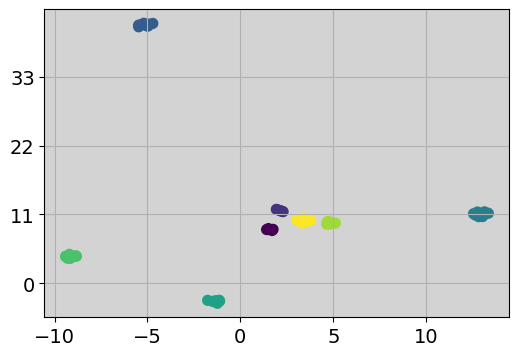

aircraft
(342, 2) (342,)


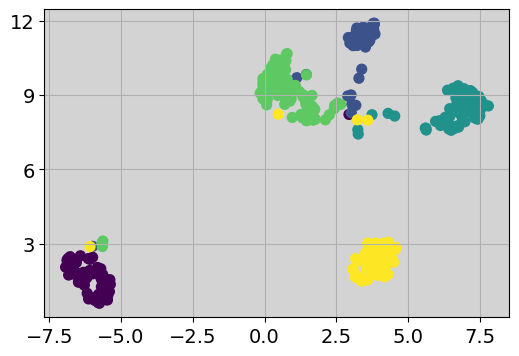

(342, 2) (342,)


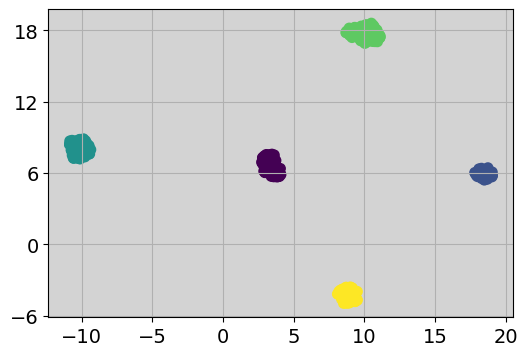

(342, 2) (342,)


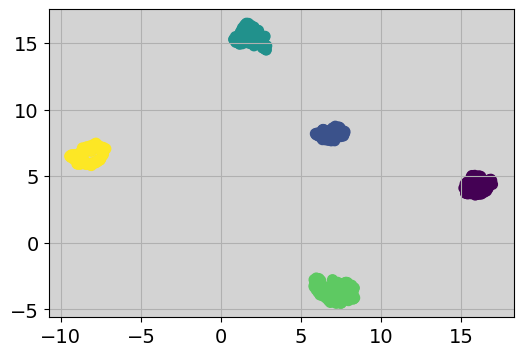

cu_birds
(199, 2) (199,)


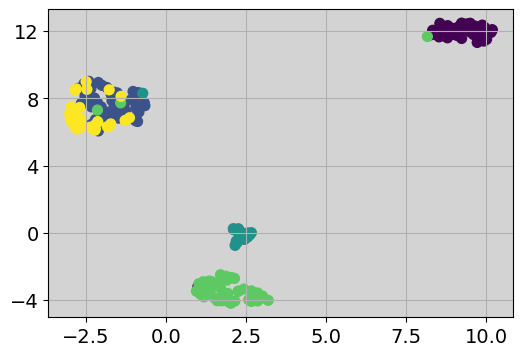

(199, 2) (199,)


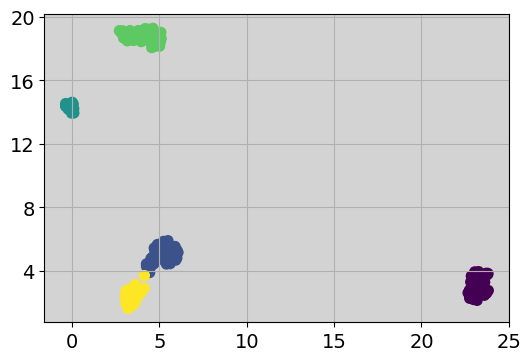

(199, 2) (199,)


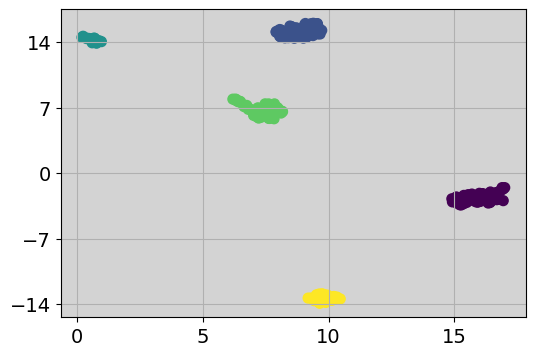

dtd
(408, 2) (408,)


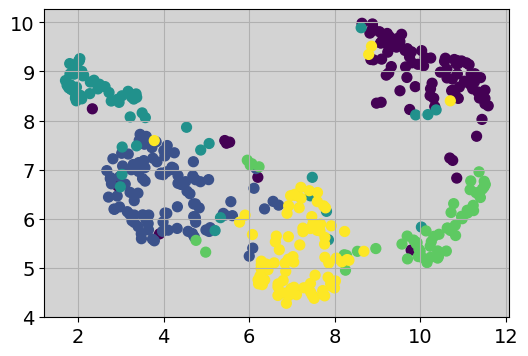

(408, 2) (408,)


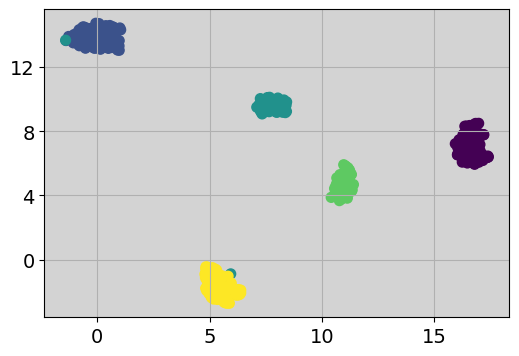

(408, 2) (408,)


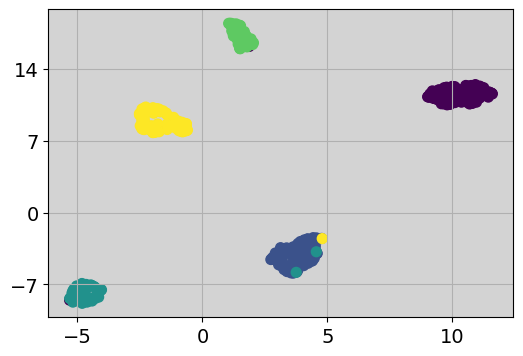

quickdraw
(135, 2) (135,)


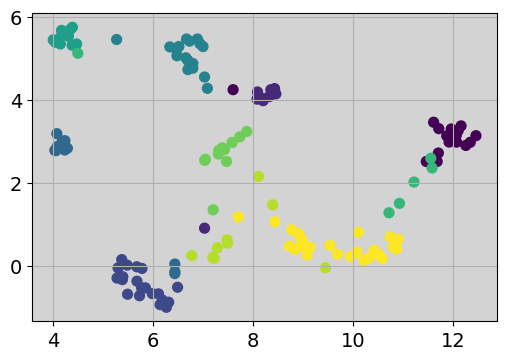

(135, 2) (135,)


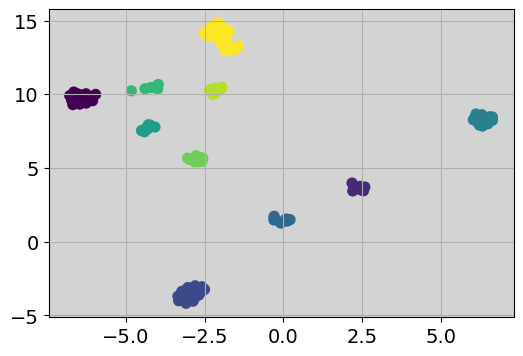

(135, 2) (135,)


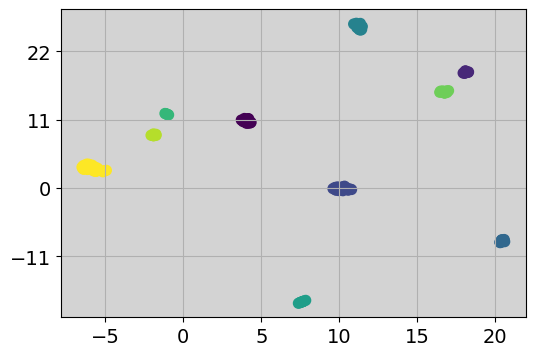

fungi
(372, 2) (372,)


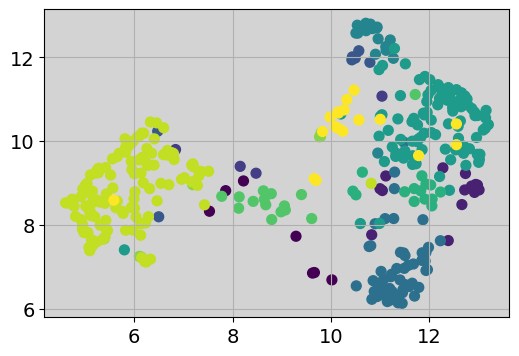

(372, 2) (372,)


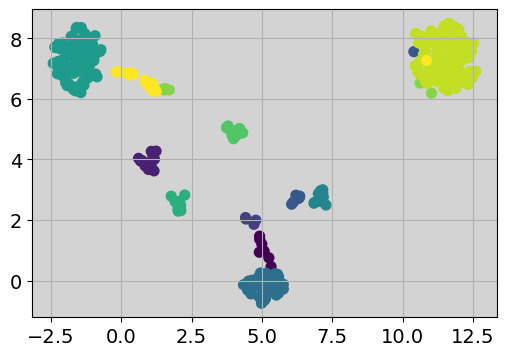

(372, 2) (372,)


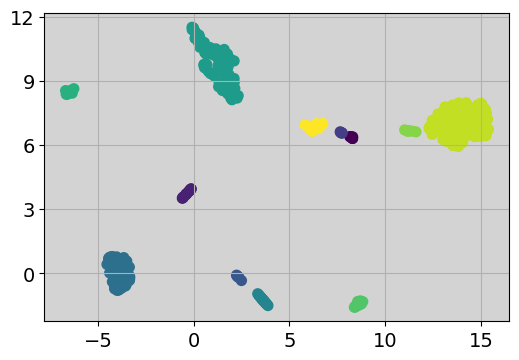

vgg_flower
(185, 2) (185,)


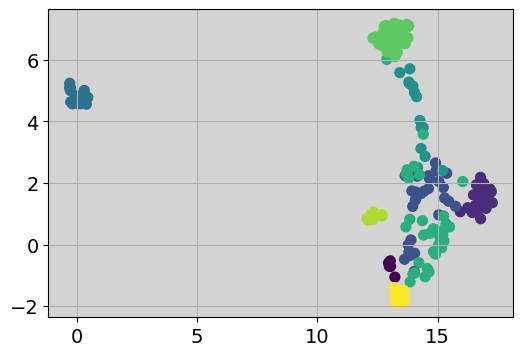

(185, 2) (185,)


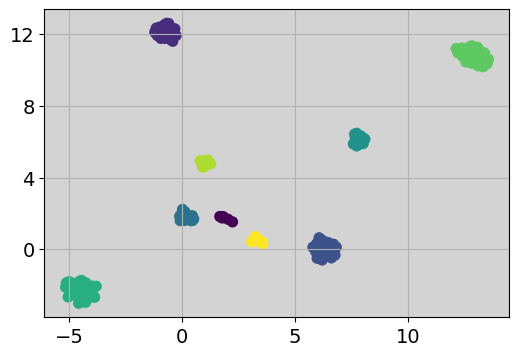

(185, 2) (185,)


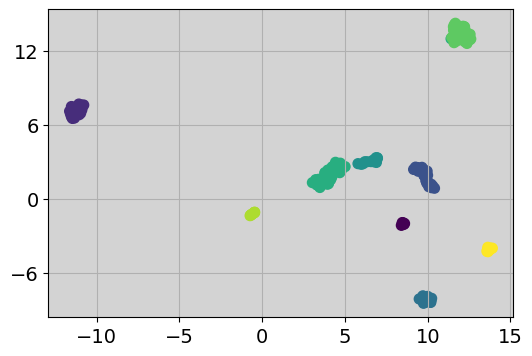

ilsvrc_2012
The gap on orig is: 0.21469148993492126


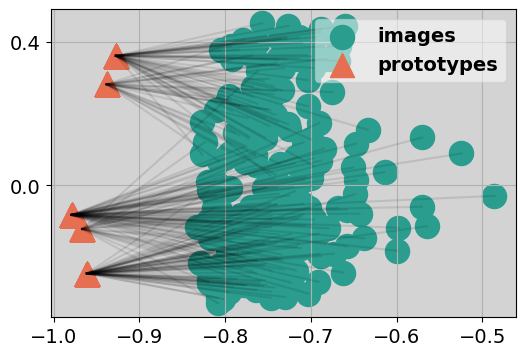

The gap on url is: 0.11627683788537979


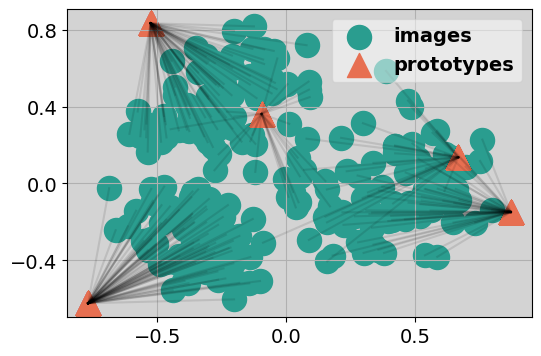

The gap on copa is: 1.3765796422958374


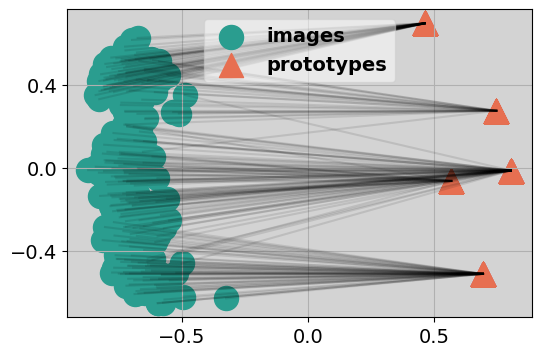

omniglot
The gap on orig is: 0.05765717849135399


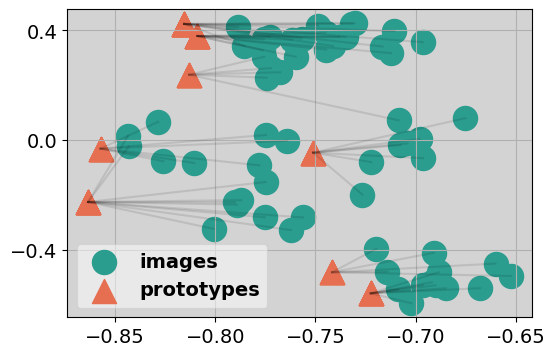

The gap on url is: 0.023545825853943825


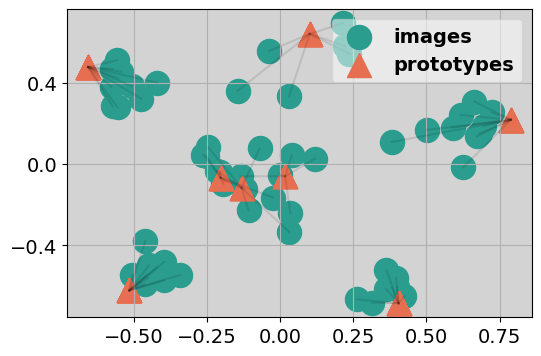

The gap on copa is: 1.352160096168518


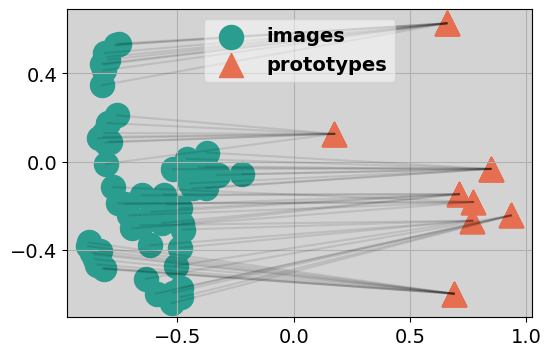

aircraft
The gap on orig is: 0.1374584138393402


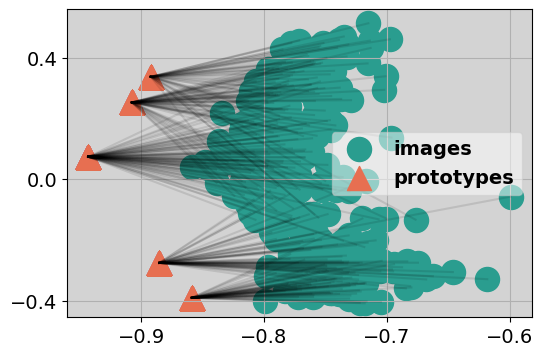

The gap on url is: 0.03844282403588295


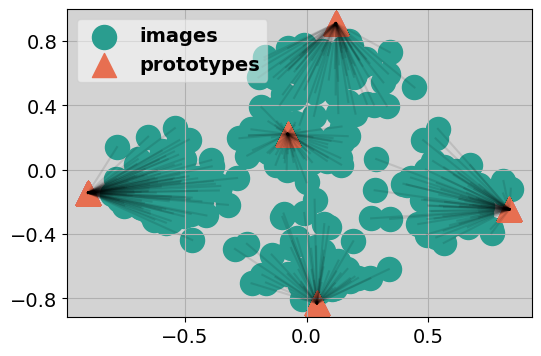

The gap on copa is: 1.770174503326416


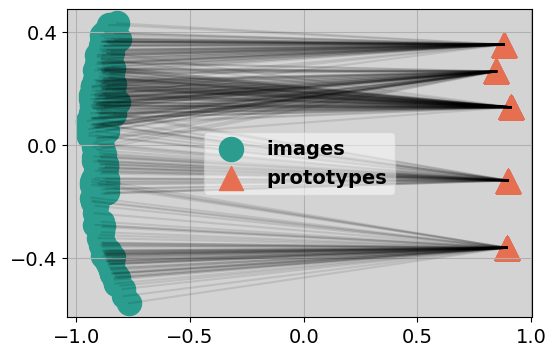

cu_birds
The gap on orig is: 0.13774123787879944


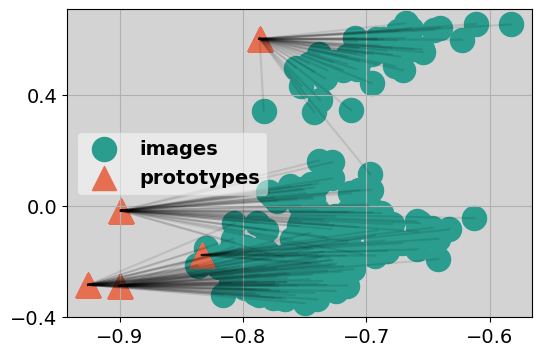

The gap on url is: 0.058434758335351944


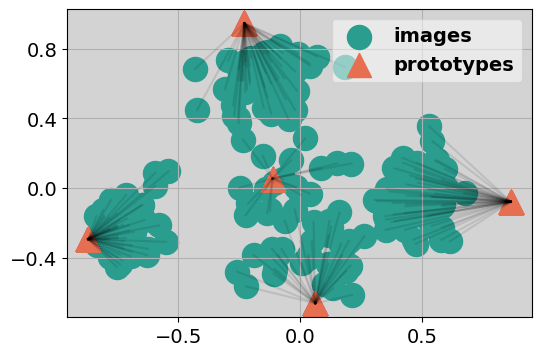

The gap on copa is: 1.6634794473648071


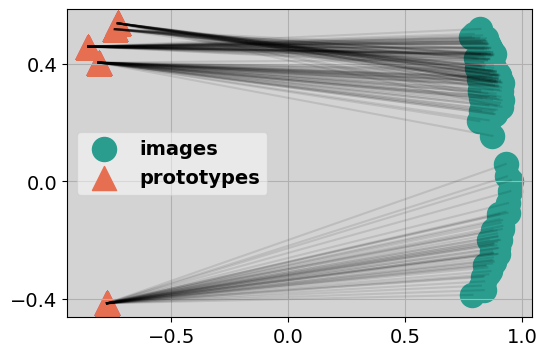

dtd
The gap on orig is: 0.22176752984523773


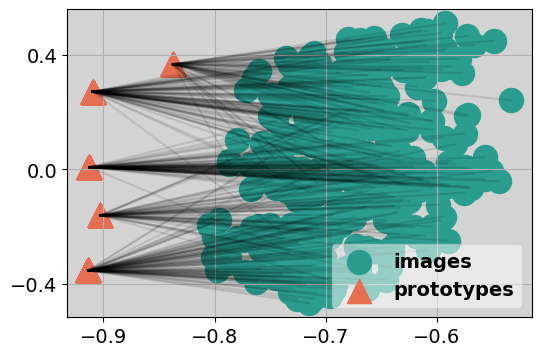

The gap on url is: 0.05841456353664398


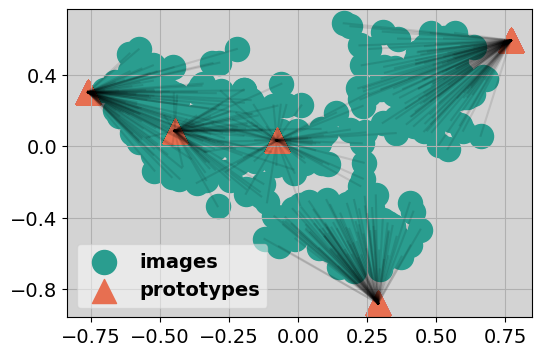

The gap on copa is: 0.6298161149024963


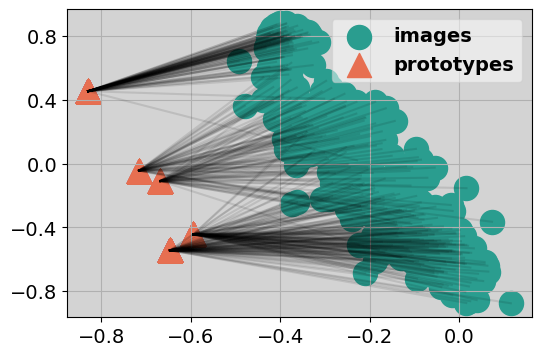

quickdraw
The gap on orig is: 0.15215064585208893


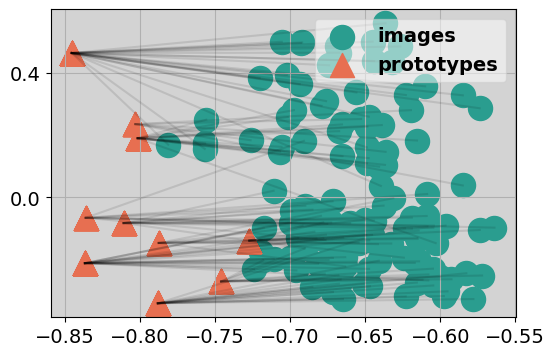

The gap on url is: 0.037089135497808456


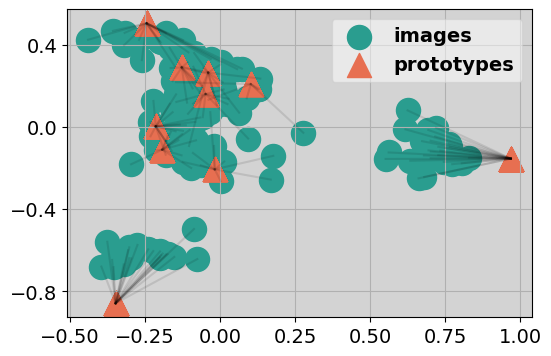

The gap on copa is: 1.3252429962158203


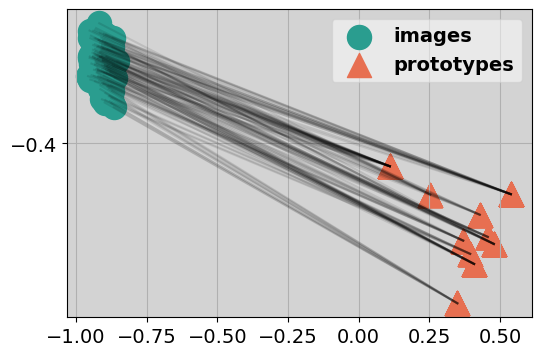

fungi
The gap on orig is: 0.20328180491924286


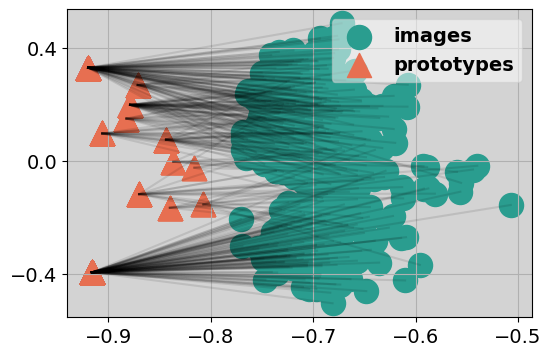

The gap on url is: 0.08415618538856506


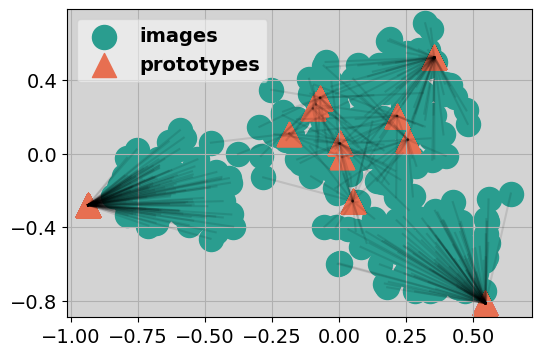

The gap on copa is: 1.7464113235473633


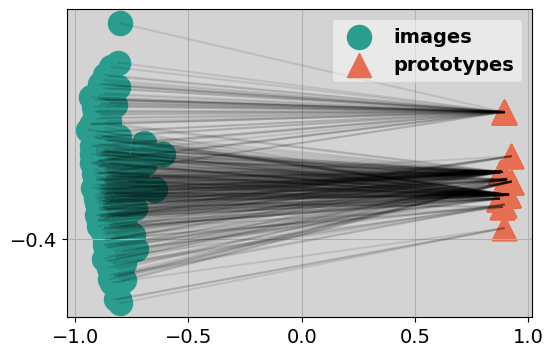

vgg_flower
The gap on orig is: 0.11948371678590775


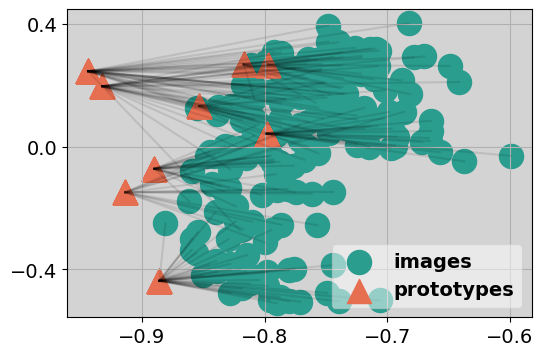

The gap on url is: 0.04727891832590103


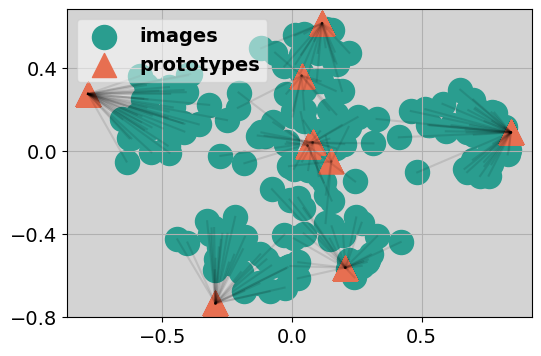

The gap on copa is: 0.7987099289894104


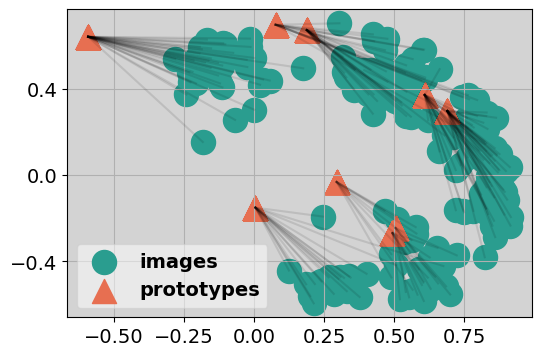

In [5]:
dataset_names = ['ilsvrc_2012', 'omniglot', 'aircraft', 'cu_birds', 'dtd', 'quickdraw', 'fungi', 'vgg_flower']
for dataset in dataset_names:
    print(dataset)
    for tp in ['orig', 'url', 'copa']:
        plot_feat_umap(dataset, tp)

dataset_names = ['ilsvrc_2012', 'omniglot', 'aircraft', 'cu_birds', 'dtd', 'quickdraw', 'fungi', 'vgg_flower']
for dataset in dataset_names:
    print(dataset)
    for tp in ['orig', 'url', 'copa']:
        draw_gap_map(dataset, tp)

The original gap of orig case is: 0.2188. Context data are on the left.


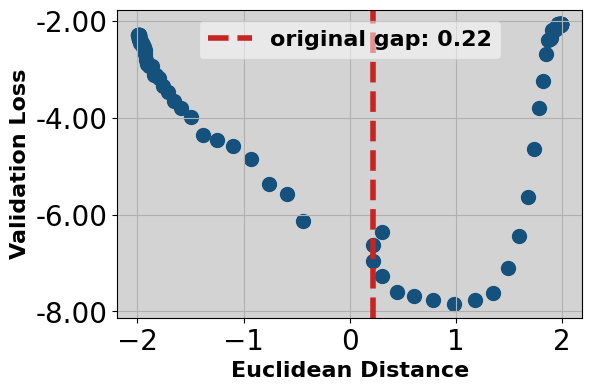

The original gap of url case is: 0.1163. Context data are on the right.


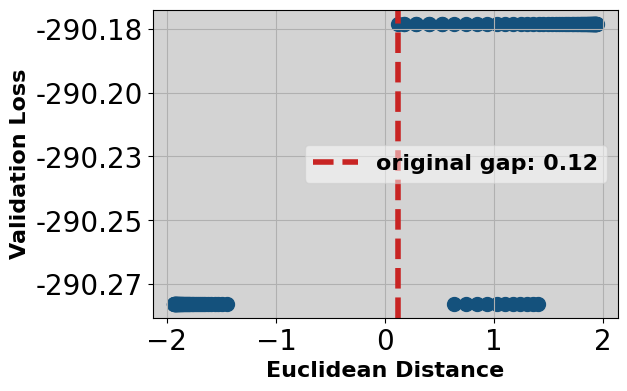

The original gap of copa case is: 1.3766. Context data are on the right.


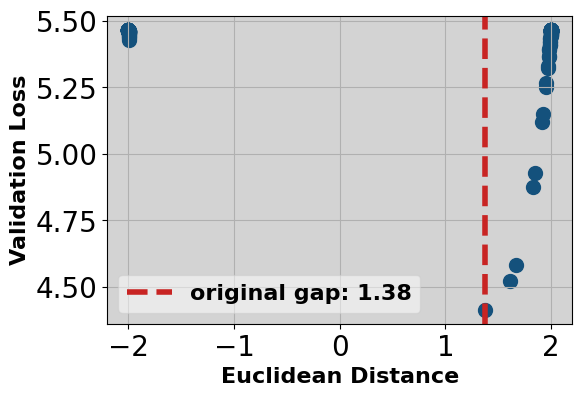

In [6]:
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
import torch
import torch.nn.functional as F
pca = PCA(n_components=6)

def compute_prototypes(context_data, context_labels):
    unique_labels = np.expand_dims(np.arange(np.max(context_labels)+1), axis=1)
    indicate_mat = np.equal(unique_labels, context_labels.reshape(1, list(context_labels.shape)[0])).astype(context_data.dtype)
    protos = np.dot(indicate_mat, context_data) / indicate_mat.sum(axis=1, keepdims=True)
    return protos

def prototype_loss(context_data, prototypes, context_labels):

    logits = np.dot(context_data, prototypes.transpose())

    log_p_y = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
    pred = np.argmax(log_p_y, axis=1)
    acc = np.equal(pred, context_labels).mean()
    loss = -np.mean(pred*context_labels)
    return acc, loss

def sce_loss(context_data, prototypes):

    context_data_tensor = torch.tensor(context_data)
    prototypes_tensor = torch.tensor(prototypes)

    logits = torch.exp(torch.tensor(2.0)) * context_data_tensor @ prototypes_tensor.t()

    pseudo_labels = torch.arange(logits.size(0)).long()

    loss = 0.5 * (F.cross_entropy(logits, pseudo_labels) + F.cross_entropy(logits.t(), pseudo_labels))

    acc = 0.0

    return acc, loss.item()

def plot_gap_changes(scale=1.0, if_line:bool=True, data_type:str='orig', mode:str="dist"):
    imagenet_data_path = './ilsvrc_2012/val_modality_gap.npy'
    data_dict = read_data(imagenet_data_path)

    #context_data, prototypes = None, None

    if data_type == 'orig':
        context_data, labels = data_dict['images'], data_dict['labels']
    elif data_type == "url":
        context_data, prototypes, labels = data_dict['transformed_images'], data_dict['transformed_prototypes'], data_dict['labels']
    elif data_type == 'copa':
        context_data, prototypes, labels = data_dict['copa_images'], data_dict['copa_prototypes'], data_dict['labels']

    context_data = context_data / (np.linalg.norm(context_data, axis=-1, keepdims=True) + 1e-12)

    if data_type == 'orig':
        protos = compute_prototypes(context_data=context_data, context_labels=labels)
    elif data_type == 'url':
        protos = prototypes
    elif data_type == 'copa':
        protos = prototypes
    
    protos = protos / (np.linalg.norm(protos, axis=-1, keepdims=True) + 1e-12)

    pca.fit(np.concatenate((context_data, protos), axis=0))
    
    context = pca.transform(context_data)[:, 0]
    proto = pca.transform(protos)[:, 0]
    if context.mean() - proto.mean() > 0:
        pos_context = 'right'
    else:
        pos_context = 'left'

    # letf minus right
    if pos_context == "left":
        delta_gap = np.linalg.norm(context_data.mean(0) - protos.mean(0))
    else:
        delta_gap = np.linalg.norm(protos.mean(0) - context_data.mean(0))
    
    print(f"The original gap of {data_type} case is: {format(delta_gap, '.4f')}. Context data are on the {pos_context}.")

    scales = []
    losses = []
    dists = []
    #print(np.arange(-2.0, 2.0, 0.2))
    for scale in np.arange(-3.0, 3.0, 0.05):
        if pos_context == "left":
            modified_data = context_data - 0.5 * scale * delta_gap
            modified_protos = protos + 0.5 * scale * delta_gap
        else:
            modified_data = context_data + 0.5 * scale * delta_gap
            modified_protos = protos - 0.5 * scale * delta_gap
        
        modified_data = modified_data / (np.linalg.norm(modified_data, axis=-1, keepdims=True)+1e-12)
        modified_protos = modified_protos / (np.linalg.norm(modified_protos, axis=-1, keepdims=True)+1e-12)

        #if data_type == 'orig':
        context_eb = pca.transform(modified_data)[:, 0]
        proto_eb = pca.transform(modified_protos)[:, 0]
        if pos_context == "left":
            sign = np.sign(proto_eb.mean() - context_eb.mean())
        else:
            sign = np.sign(context_eb.mean() - proto_eb.mean())
        #sign = np.sign(context_eb.mean() - proto_eb.mean())

        if data_type == 'orig' or data_type =='url':
            _, loss = prototype_loss(context_data=modified_data, prototypes=modified_protos, context_labels=labels)
        elif data_type == 'copa':
            _, loss = sce_loss(modified_data, modified_protos)

        scales.append(scale)
        losses.append(loss)
        dists.append(sign*np.linalg.norm(modified_data.mean(0) - modified_protos.mean(0)))

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    ax.patch.set_facecolor('#D3D3D3')

    font = {'weight': 'bold', 'size': 16}
    legend_font = {'weight': 'bold', 'size': 16}
    # distance version
    if mode == "dist":
        ax.scatter(dists, losses, marker='o', s=100, color="#14517C")
        plt.axvline(x=delta_gap, color='#C82423', linestyle='--', linewidth=4, label=f"original gap: {format(delta_gap, '.2f')}")
        #ax.annotate(f"original gap={np.round(delta_gap, 2)}")
        plt.xlabel("Euclidean Distance", fontdict=font)
        plt.legend(prop=legend_font, framealpha=.5)
    elif mode == "abs_dist":
        print(dists)
        print(losses)
        abs_dists = [abs(val) for val in dists]
        ax.plot(abs_dists, losses)
    elif mode == "scale":
        ax.plot(scales, losses, linewidth=4)
        ax.scatter(scales, losses, marker='o', s=100)
        plt.axvline(x=0, color='black', linestyle='--', linewidth=4)
        plt.xlabel("Scale of Gap", fontdict=font)
        
    
    plt.ylabel("Validation Loss", fontdict=font)
    #if data_type == 'orig':
    #y_axis_locator = MultipleLocator()
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.tick_params(labelsize=20)
    plt.grid(True)

    save_path = os.path.join('./figs', 'curves')
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    if data_type == 'orig':
        filename = 'validation_loss_embed.pdf' if mode == "scale" else 'validation_loss_embed_euclidean.pdf'
        fig_name = os.path.join(save_path, filename)
    elif data_type == 'url':
        filename = 'validation_loss_url.pdf' if mode == "scale" else 'validation_loss_url_euclidean.pdf'
        fig_name = os.path.join(save_path, filename)
    elif data_type == 'copa':
        filename = 'validation_loss_copa.pdf' if mode == "scale" else 'validation_loss_copa_euclidean.pdf'
        fig_name = os.path.join(save_path, filename)
    plt.savefig(fig_name, dpi=300, bbox_inches='tight')

    plt.show()
    plt.close()

#plot_gap_changes(mode="scale")
plot_gap_changes(mode="dist")
plot_gap_changes(data_type='url', mode="dist")
plot_gap_changes(if_line=False, data_type='copa', mode="dist")